In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, BatchNormalization, Dropout, Concatenate
from keras.utils import plot_model

In [2]:
MYwd= os.getcwd()
file_path = MYwd+"\GitHub DAV\mortality.csv"

df = pd.read_csv(file_path)

# add a column with the mortality rates (originally, only the log_mortality rates are included)
df['mortality'] = np.exp(df['log_mortality'])

# the dataset contains data from west and east germany seperately. we only use the rates for the entire population of germany (DEUT)
df = df[(df['Country'].isin(["CHE","DEUT","DNK", "ESP", "FRATNP", "ITA", "JPN", "POL", "USA"]))]

print(df.head(10))
#print(df.info())

  Country  Year  Gender  Age  log_mortality  mortality
0     CHE  1950  Female    0      -3.601125   0.027293
1     CHE  1950  Female    1      -5.793926   0.003046
2     CHE  1950  Female    2      -6.392539   0.001674
3     CHE  1950  Female    3      -6.697494   0.001234
4     CHE  1950  Female    4      -6.900780   0.001007
5     CHE  1950  Female    5      -7.476916   0.000566
6     CHE  1950  Female    6      -7.374564   0.000627
7     CHE  1950  Female    7      -7.469874   0.000570
8     CHE  1950  Female    8      -7.492945   0.000557
9     CHE  1950  Female    9      -7.885921   0.000376


In [3]:
# We houden age ook even als numerieke variable, gender en country zijn categorisch
df['Country'] = df['Country'].astype('category').cat.codes
df['Gender'] = df['Gender'].astype('category').cat.codes

df['Year'] = df['Year'].astype('float')    # neural nets kunnen niet goed met ints werken
df['Age'] = df['Age'].astype('float')


In [4]:
# Set up the training set
country = 5
gender = 0

filtered = df[(df['Country'] == country)]

train = filtered[(filtered['Year'].between(1956, 2005))].copy()

train = shuffle(train, random_state=42)     # random_state is gelijk set.seed() (elke keer dezelfde shuffle)

test_set = filtered[(filtered['Year'].between(2006, 2016))].copy()

In [5]:
year_mean, year_std = train['Year'].mean(), train['Year'].std()
age_mean, age_std = train['Age'].mean(), train['Age'].std()

In [6]:
# function to normalize and prepare the data for training

def normalize_data(data, embed_age=True):
    year = data['Year'].values.reshape(-1,1)
    age = data['Age'].values.reshape(-1,1)
    gender = data['Gender'].values.reshape(-1,1)
    #country = data['Country'].values.reshape(-1,1)
    
    #year_mean, year_std = year.mean(), year.std()
    #age_mean, age_std = age.mean(), age.std()
    
    year_norm = (year - year_mean) / year_std
    age_norm = (age - age_mean) / age_std
    
    if embed_age:
        #X = [year_norm, age, gender, country]
        X = [year_norm, age, gender]
    else:
        #X = [year_norm, age_norm, gender, country]
        X = [year_norm, age_norm, gender]
    
    Y = data['log_mortality'].values.reshape(-1,1)
    
    return X, Y

In [7]:
# Build the neural network model

def build_model(embed_age=True):
    
    # Define the input layers
    year = Input(shape=(1,), dtype='float32', name='year')
    age = Input(shape=(1,), dtype='float32', name='age')
    gender = Input(shape=(1,), dtype='float32', name='gender')
    #country = Input(shape=(1,), dtype='float32', name='country')
    
    # Define embedding layers for categorical variables
    age_embed = Embedding(input_dim=101, output_dim=20, name='age_embed')(age)
    age_embed = Flatten()(age_embed)

    gender_embed = Embedding(input_dim=2, output_dim=2, name='gender_embed')(gender)
    gender_embed = Flatten()(gender_embed)
    
    #country_embed = Embedding(input_dim=9, output_dim=3, name='country_embed')(country)
    #country_embed = Flatten()(country_embed)
    
    # Concatenate the defined features
    if embed_age:
        #features = Concatenate()([year, age_embed, gender_embed, country_embed])
        features = Concatenate()([year, age_embed, gender_embed])
    else:
        #features = Concatenate()([year, age, gender_embed, country_embed])
        features = Concatenate()([year, age, gender_embed])
    
    # Define the hidden layers
    d1 = Dense(units=256, activation='relu')(features)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.2)(d1)
    
    d2 = Dense(units=256, activation='relu')(d1)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.2)(d2)

    # Define the output layer
    target = Dense(units=1, activation='linear')(d2)
    
    #model = Model(inputs=[year, age, gender, country], outputs=target)
    model = Model(inputs=[year, age, gender], outputs=target)

    adam_optimizer = tf.keras.optimizers.Adam(0.0005)
    model.compile(optimizer=adam_optimizer, loss='mse')
    
    return model

In [8]:
# Training the model
X_train, Y_train = normalize_data(train, embed_age=True)
X_test, Y_test = normalize_data(test_set, embed_age=True)

model = build_model()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=40, verbose=1, restore_best_weights=True)
# we fitten het model nu zonder validation split omdat we de beste architecture hebben gekozen en nu trainen we dat netwerk met 
# alle trainingsdata en kijken dan naar de performance op de test data
history = model.fit(x=X_train, y=Y_train, batch_size=128, epochs=150, verbose=1)

Epoch 1/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 28.8802
Epoch 2/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.8745
Epoch 3/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1700
Epoch 4/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0367
Epoch 5/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7622
Epoch 6/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5766
Epoch 7/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3968
Epoch 8/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3557
Epoch 9/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2876
Epoch 10/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2321
Epoch 11/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1293
Epoch 12/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0445
Epoch 13/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0472
Epoch 14/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9775
Epoch 15/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9236
Ep

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1680
Epoch 83/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1935
Epoch 84/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1811
Epoch 85/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2002
Epoch 86/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1843
Epoch 87/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1689
Epoch 88/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1662
Epoch 89/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1673
Epoch 90/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1670
Epoch 91/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1694
Epoch 92/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1459
Epoch 93/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1785
Epoch 94/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1627
Epoch 95/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1602
Epoch 96/150
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1527
Epoch 97

In [9]:
# loss on training data: 
score_train = model.evaluate(X_train, Y_train, verbose=0)
print(score_train)

score = model.evaluate(X_test, Y_test, verbose=0)

print(model.metrics_names)
print(score)

0.022748876363039017
['loss']
0.04366416111588478


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
        Country    Year  Gender    Age  log_mortality  mortality  prediction
102414        5  2006.0       0    0.0      -5.799853   0.003028   -5.738932
102415        5  2006.0       0    1.0      -8.492501   0.000205   -8.634857
102416        5  2006.0       0    2.0      -8.971323   0.000127   -9.002987
102417        5  2006.0       0    3.0      -9.315701   0.000090   -9.244123
102418        5  2006.0       0    4.0      -8.715644   0.000164   -9.388807
...         ...     ...     ...    ...            ...        ...         ...
104227        5  2014.0       1   96.0      -1.150972   0.316329   -0.812253
104228        5  2014.0       1   97.0      -1.072088   0.342293   -0.777157
104229        5  2014.0       1   98.0      -0.949398   0.386974   -0.755853
104230        5  2014.0       1   99.0      -0.907827   0.403400   -0.603191
104231        5  2014.0       1  100.0      -0.784195   0.456487   -0.510125

[1818 rows x 7 columns]


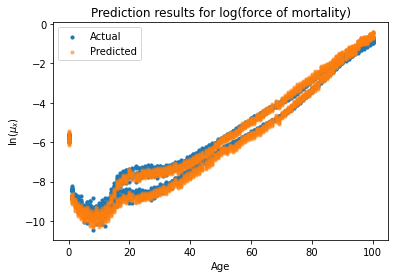

In [10]:
# predictions on the test set: 
predic = model.predict(X_test)

test_set['prediction'] = predic
print(test_set)

plt.scatter(test_set['Age'], test_set['log_mortality'], label="Actual", s=10)
plt.scatter(test_set['Age'], test_set['prediction'], label="Predicted", alpha=0.5, s=10)
plt.legend()
plt.title('Prediction results for log(force of mortality)')
plt.xlabel('Age')
plt.ylabel('$\ln(\mu_x)$')
plt.show()

In [11]:
years = test_set['Year'].drop_duplicates()

mse_df = pd.DataFrame(columns=['Country', 'Year', 'MSE_NN'])
index = 0

for year in years:
    subset = test_set[test_set['Year'] == year]
    
    mse = mean_squared_error(subset['log_mortality'], subset['prediction'])
    
    mse_df.loc[index] = [country, year, mse]
    index += 1
        
    
mse_df

,Country,Year,MSE_NN
0,5.0,2006.0,0.030685
1,5.0,2007.0,0.036595
2,5.0,2008.0,0.032794
3,5.0,2009.0,0.042576
4,5.0,2010.0,0.042562
5,5.0,2011.0,0.047652
6,5.0,2012.0,0.048101
7,5.0,2013.0,0.053972
8,5.0,2014.0,0.058041
